In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from time import time
from k_medoids import KMedoids
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_preparation import DataPreparation
from dissimilarity_matrix import DissimilarityMatrix


In [2]:
# get path to multi resolution hic data
path_wt = '/home/elinfi/coolers/HiC_wt_001.mcool'
path_cancer = '/home/elinfi/coolers/HiC_cancer_001.mcool'

resolution = 32000
region = 'chr4:5M-7M' # region of genome

# create objects of class
wt = DataPreparation(path_wt, resolution, region)
cancer = DataPreparation(path_cancer, resolution, region)

# create balanced matrices (not necessary for the following steps)
balance = True
wt.create_matrix(balance=balance)
cancer.create_matrix(balance=balance)

# divide matrices
#diff_mat = wt.divide(cancer, replace_zero_zero=False)
diff_mat = cancer.subtract(wt)

[Text(0.5, 1.0, 'Cancer')]

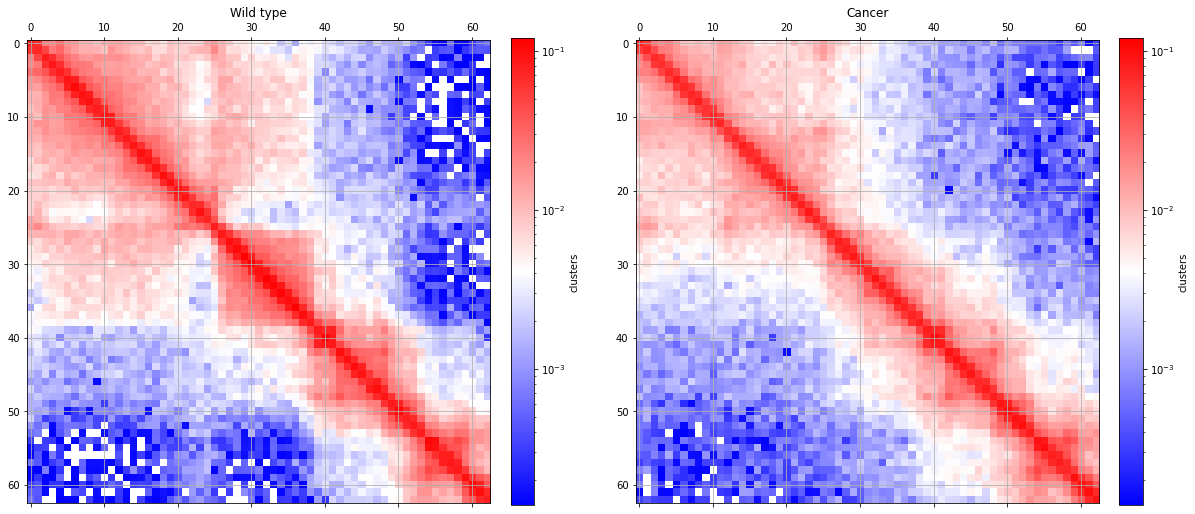

In [3]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

norm = mpl.colors.LogNorm()
#norm = None

ax = axs[0]
im = ax.matshow(wt.matrix,
                norm=norm,
                cmap='bwr',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.grid(b=True)
ax.set(title='Wild type')

ax = axs[1]
im = ax.matshow(cancer.matrix,
                norm=norm,
                cmap='bwr',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.grid(b=True)
ax.set(title='Cancer')

In [4]:
# create distance matrix
#scaler = StandardScaler()
metric='row_col_dist'
scaler=None
remove_nan = True
w1 = 1
w2 = 0.01

dissimilarity = DissimilarityMatrix(diff_mat)

# coordinates of last element on the diagonal
diag = np.array([dissimilarity.n, dissimilarity.n])

# unit vector for last diagonal element
diag_unit = diag/np.linalg.norm(diag)

# diagonal distance = row - col
start = time()
distmat_row_col = dissimilarity.scipy_dist(metric=metric, 
                                           scaler=scaler, 
                                           remove_nan=remove_nan,
                                           w1=w1, 
                                           w2=w2)
end = time()
print(f'Time row_column: {end - start}')


Time row_column: 6.82995080947876


In [5]:
### calculate kmedoids clusters
medoids = 5
random_state = 19

n = dissimilarity.n
triu_nan_idx = dissimilarity.triu_nan_idx

# row - column distance
k_medoids_row_col = KMedoids(distmat_row_col)
clusters_row_col = k_medoids_row_col.clusters(medoids=medoids, 
                                              random_state=random_state)
labels_mat_row_col = k_medoids_row_col.labels4plotting_nan(n, triu_nan_idx)


In [6]:
# create discrete colormap
cmap = plt.cm.cool
bounds = np.linspace(0, medoids, medoids+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

0


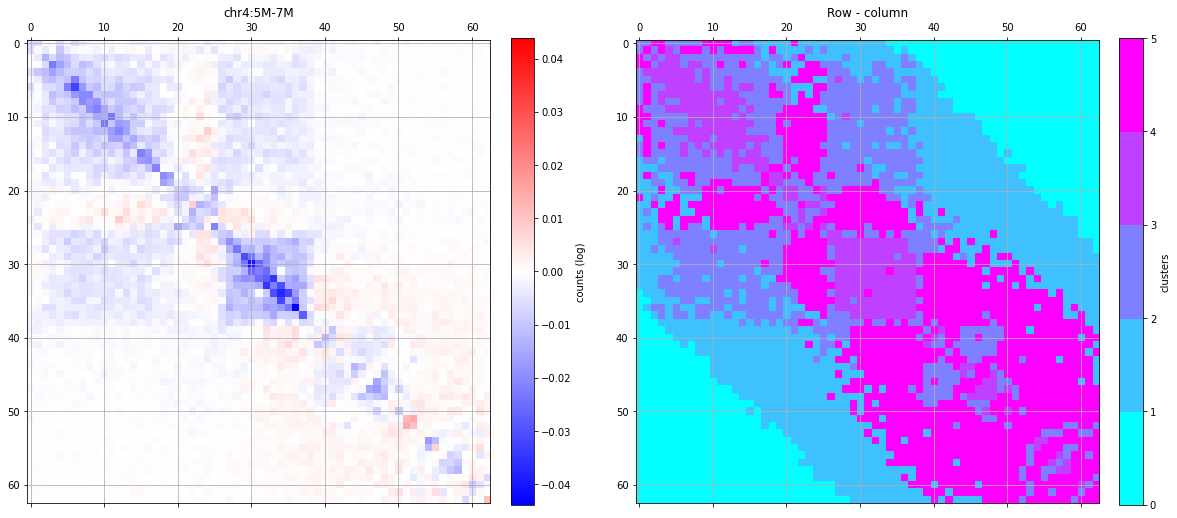

In [7]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

ax = axs[0]
vmax = np.nanmax(abs(diff_mat))
im = ax.matshow(diff_mat,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='counts (log)', ax=ax)
ax.grid(b=True)
ax.set(title=region)

ax = axs[1]
im = ax.matshow(labels_mat_row_col,
                norm=norm,
                cmap=cmap,
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.grid(b=True)
ax.set(title='Row - column')

print(np.sum(np.isnan(labels_mat_row_col)))

In [8]:
xy = xy = np.ones((n, n))*np.linspace(0, n-1, n)
x = xy.flatten(order='F')
y = xy.flatten(order='C')

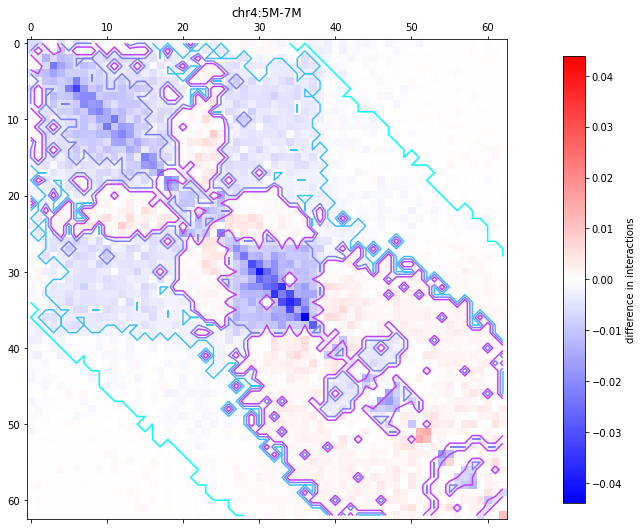

In [9]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)

ax = axs
vmax = np.nanmax(abs(diff_mat))
im = ax.matshow(diff_mat,
                #norm=mpl.colors.LogNorm(),
                cmap='bwr',
                vmin=-vmax,
                vmax=vmax)
plt.colorbar(im, fraction=0.04, pad=0.1, label='difference in interactions', ax=ax)

im = ax.contour(labels_mat_row_col,
                norm=norm,
                cmap='cool',
                levels=bounds,
                alpha=1)
#plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.set(title=region)
ax.set_facecolor('xkcd:green')